# Question_1 Data Cleaning

In [3]:
# I put these codes here in case you con't have these libraries in Data Scientist Workbench.
!pip install bs4
!pip install wordcloud

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
import string
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from time import time
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.feature_selection import chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import seaborn as sns
from IPython.display import display
from sklearn import metrics

#### Clean US_airline_tweets.csv

In [2]:
df_1 = pd.read_csv('US_airline_tweets.csv') # read csv file
df_1.head()

,id,sentiment,negative_reason,user,retweet_count,text
0,5.703010e+17,positive,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...
3,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...
4,5.703010e+17,positive,NaN,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX..."


In [3]:
df_1.groupby('sentiment').size() #chech the amount of negative tweets and positive tweets

sentiment
negative    9178
positive    2363
dtype: int64

In [4]:
pat1 = r'https?://[A-Za-z0-9./]+'
pat2 = r'<[^>]+>'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
abbr_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(abbr_dic.keys()) + r')\b') #Expand abbr. in order to remove stopwords.

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/baronma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'html.parser') #Replace html character codes with an ASCII equivalent.
    souped = soup.get_text()
    try:
        bom_removed = souped.replace(u'\x9d', '').replace(u'\x81', '').replace(u'\x8d', '').replace(u'\x8f', '')
    except:
        bom_removed = souped #Rrmove html hash tags.
    stripped = re.sub(combined_pat, '', bom_removed) #Remove html attributes and URLs.
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower() #All characters in the text are in lowercase.
    neg_handled = neg_pattern.sub(lambda x: abbr_dic[x.group()], lower_case)
    stopwords.words('english')
    en_stops = set(stopwords.words('english'))
    neg_handled = neg_handled.split()
    words = [w for w in neg_handled if not w in en_stops] #Remove stopwords.
    return (" ".join(words)).strip()

In [7]:
result = []
for tw in df_1['text']:
    re_nonascii = re.sub(r'[^\x00-\x7f]+', " ", tweet_cleaner(tw)) #remove some non-ascii chars
    result.append(re_nonascii)
result

['@virginamerica plus added commercials experience... tacky.',
 '@virginamerica really aggressive blast obnoxious "entertainment" guests\' faces & little recourse',
 '@virginamerica really big bad thing',
 '@virginamerica seriously would pay $30 flight seats playing. really bad thing flying va',
 '@virginamerica yes, nearly every time fly vx  ear worm  won t go away :)',
 "@virginamerica well, didn't but do! :-d",
 '@virginamerica amazing, arrived hour early. good me.',
 '@virginamerica <3 pretty graphics. much better minimal iconography. :d',
 '@virginamerica great deal! already thinking 2nd trip @australia & even gone 1st trip yet! ;p',
 "@virginamerica @virginmedia i'm flying #fabulous #seductive skies again! u take #stress away travel",
 '@virginamerica thanks!',
 '@virginamerica sfo-pdx schedule still mia.',
 "@virginamerica excited first cross country flight lax mco i've heard nothing great things virgin america. #29daystogo",
 '@virginamerica flew nyc sfo last week could fully s

As you can see in the result, there are still @, # and some punctuation left. It is becasue @ and # are helpful when I do some research below.

In [8]:
clean_df = pd.DataFrame(result,columns=['text'])
clean_df['sentiment'] = df_1.sentiment
clean_df['negative_reason'] = df_1.negative_reason # put useful columns in a new dataframe.
clean_df.head()

,text,sentiment,negative_reason
0,@virginamerica plus added commercials experien...,positive,NaN
1,@virginamerica really aggressive blast obnoxio...,negative,Bad Flight
2,@virginamerica really big bad thing,negative,Can't Tell
3,@virginamerica seriously would pay $30 flight ...,negative,Can't Tell
4,"@virginamerica yes, nearly every time fly vx ...",positive,NaN


In [8]:
clean_df.to_csv('cleaned_US_airline_tweets.csv',encoding='utf-8')

#### Clean generic_tweets.txt

In [9]:
df_2 = pd.read_csv('generic_tweets.txt')
df_2.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [10]:
df_2.groupby('class').size()

class
0    100000
4    100000
dtype: int64

In [11]:
result_2 = []
for tw in df_2['text']:
    re_nonascii_2 = re.sub(r'[^\x00-\x7f]+', " ", tweet_cleaner(tw))
    no_punc = re.sub(r'[^\w\s]','',re_nonascii_2) # remove all the punctuations
    result_2.append(no_punc)
result_2

['switchfoot  awww thats bummer shoulda got david carr third day it d',
 'upset update facebook texting it might cry result school today also blah',
 'kenichan dived many times ball managed save 50 rest go bounds',
 'whole body feels itchy like fire',
 'nationwideclass no behaving all im mad here see there',
 'kwesidei whole crew',
 'need hug',
 'loltrish hey long time see yes rains bit only bit lol  im fine thanks  hows ',
 'tatiana_k nope',
 'twittera que muera ',
 'spring break plain city snowing',
 'repierced ears',
 'caregiving could bear watch it thought ua loss embarrassing     ',
 'octolinz16 counts idk either never talk anymore',
 'smarrison wouldve first gun really though zac snyders doucheclown',
 'iamjazzyfizzle wish got watch you miss iamlilnicki premiere',
 'hollis death scene hurt severely watch film wry directors cut now',
 'file taxes',
 'lettya ahh ive always wanted see rent love soundtrack',
 'fakerpattypattz oh dear drinking forgotten table drinks',
 'alydesigns day

In [12]:
clean_df_2 = pd.DataFrame(result_2,columns=['text'])
clean_df_2['class'] = df_2['class']

In [13]:
clean_df_2.to_csv('cleaned_generic_tweets.csv',encoding='utf-8')

# Question_2 Exploratory analysis

#### (1) Determine the airline of a given tweet

In [14]:
# turn 'positive' and 'negative' into 4 and 0 i for future use
clean_df['sentiment_num'] = ''
i = 0
while i < len(clean_df):
    sentiment_num = 0
    if clean_df.sentiment[i] == 'positive':
        sentiment_num = 4
    clean_df.sentiment_num[i] = sentiment_num
    i = i + 1

In [15]:
dis_df = clean_df.copy() # build a new dataframe to do the second question

In [16]:
dis_df['all airline'] = '' # build a new column to contain all airlines

In [17]:
search_words = ['@virginamerica', '@united', '@southwestair', '@jetblue', '@usairways', '@americanair', '@delta']
i = 0
while i < len(dis_df):
    air = []
    for word in search_words:
        if word in dis_df.text[i]:
            air.append(word[1:])
            dis_df['all airline'][i] = str(air)[1: -1].replace("'", "")
    i = i + 1

In [18]:
dis_df.head()

,text,sentiment,negative_reason,sentiment_num,all airline
0,@virginamerica plus added commercials experien...,positive,NaN,4,virginamerica
1,@virginamerica really aggressive blast obnoxio...,negative,Bad Flight,0,virginamerica
2,@virginamerica really big bad thing,negative,Can't Tell,0,virginamerica
3,@virginamerica seriously would pay $30 flight ...,negative,Can't Tell,0,virginamerica
4,"@virginamerica yes, nearly every time fly vx ...",positive,NaN,4,virginamerica


In [19]:
print(dis_df['all airline'][10799])

usairways, americanair


In [20]:
dis_df.groupby('all airline').size()

all airline
                                                        1
americanair                                          2206
americanair, delta                                     14
delta                                                   2
jetblue                                              1481
jetblue, americanair                                    7
jetblue, americanair, delta                             4
jetblue, delta                                          1
jetblue, usairways                                      1
jetblue, usairways, americanair                         1
southwestair                                         1721
southwestair, americanair                              11
southwestair, delta                                     9
southwestair, jetblue                                   5
southwestair, jetblue, delta                            1
southwestair, usairways                                14
southwestair, usairways, delta                          1
un

I planned to find all the airlines mentioned in each tweet, because there are several tweets including more than one airlines. However even though I can find all of the airlines in every tweet, it's very hard to do analysis beased on so many variables. And on the other hand, tweets that only contain one airline is much more than tweets containing >1 airlines. As a result, I will only extract the first airline mentioned in every tweet to do further analysis.

In [21]:
dis_df['airline'] = '' # build a column to include the first airline mentioned of every tweet

In [22]:
search_words = ['@virginamerica', '@united', '@southwestair', '@jetblue', '@usairways', '@americanair']
i = 0
while i < len(dis_df):
    air2 = []
    for word in search_words:
        if word in dis_df.text[i]:
            air2.append(word[1:])
            dis_df.airline[i] = str(air2[0]).replace("'", "") # extract the first airline mentioned in all tweets
    i = i + 1

In [23]:
dis_df.groupby('airline').size()

airline
                    3
americanair      2220
jetblue          1495
southwestair     1762
united           3159
usairways        2560
virginamerica     342
dtype: int64

Roughly speaking, we can konw the times each airline are mentioned by all whese tweets.

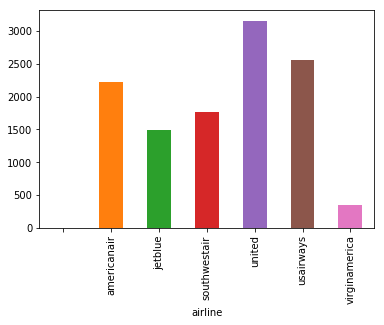

In [24]:
dis_df.groupby('airline').size().plot.bar() # show the times of each airline mentioned by given tweets visually

In [26]:
i = 0
virgin = 0
united = 0
southwest = 0
jetblue = 0
usair = 0
amerair = 0
for tw in dis_df['airline']:
    if tw == 'virginamerica':
        virgin += dis_df.sentiment_num[i]
    elif tw == 'united':
        united += dis_df.sentiment_num[i]
    elif tw == 'jetblue':
        jetblue += dis_df.sentiment_num[i]
    elif tw == 'southwestair':
        southwest += dis_df.sentiment_num[i]
    elif tw == 'usairways':
        usair += dis_df.sentiment_num[i]
    elif tw == 'americanair':
        amerair += dis_df.sentiment_num[i]
    i = i + 1
virgin = virgin / 342
united = united / 3159
southwest = southwest / 1762
jetblue = jetblue / 1495
usair = usair / 2560
amerair = amerair / 2220 # calculate the satisfaction lavel of each airline

In [27]:
print(virgin); print(usair); print(amerair); print(jetblue); print(united); print(southwest)

1.7777777777777777
0.421875
0.5963963963963964
1.4528428093645485
0.6293130737575182
1.2917139614074915


In [28]:
# build a new dataframe to put the six variables above
airlinedf = pd.DataFrame([[virgin, united, southwest, jetblue, usair, amerair]], index = ['airlines'], columns = pd.Index(['virginamerica', 'united', 'southwestair', 'jetblue', 'usairways', 'americanair'], name = 'Airlines'))

In [29]:
airlinedf

Airlines,virginamerica,united,southwestair,jetblue,usairways,americanair
airlines,1.777778,0.629313,1.291714,1.452843,0.421875,0.596396


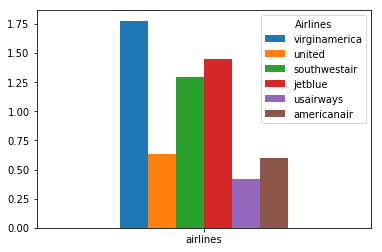

In [30]:
airlinedf.plot.bar(rot = 360)

As you can see from the two histgram above, United airline is most frequently mentioned and the Virginamerica airline is the least frequently mentioned in the given tweets. However if I sum all the numbers (0 and 4) and get the whole socres of each airline, then get the mean scores of each airline fairly, we can see Virginamerica is the most satisfying, but the Usairways is the least satisfying.

#### (2) Present a word cloud to show the frequency of some keywords.

In [31]:
neg_string = []
neg_tweets = clean_df_2[clean_df_2['class'] == 0]
for tw in neg_tweets.text:
    neg_string.append(tw)
neg_string = pd.Series(neg_string).str.cat(sep = '')

In [32]:
pos_string = []
pos_tweets = clean_df_2[clean_df_2['class'] == 4]
for tw in pos_tweets.text:
    pos_string.append(tw)
pos_string = pd.Series(pos_string).str.cat(sep = '')

The codes above are used to separate the negative tweets and positive tweets.

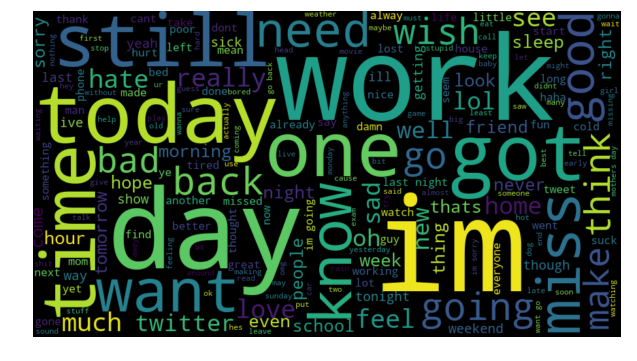

In [72]:
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=200,
                      max_font_size=200,
                      relative_scaling = 0.5,
                      stopwords = set(STOPWORDS)
                      ).generate(neg_string)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

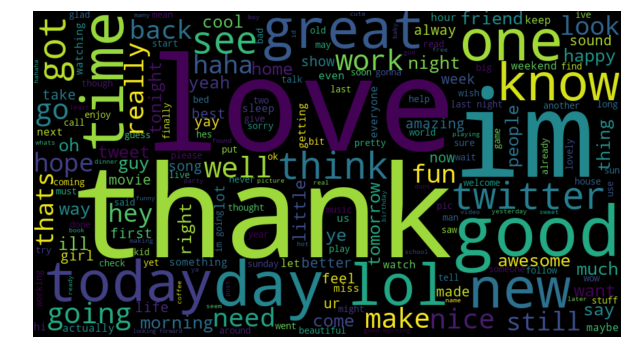

In [73]:
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=200,
                      max_font_size=200,
                      relative_scaling = 0.5,
                      stopwords = set(STOPWORDS)
                      ).generate(pos_string)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

From the two pics above, we can see that in negative tweets, words like 'work', 'hate' appear frequently. On the contrary, in the positive tweets, words like 'good', 'love' appear most.

In [75]:
# We have already known that Usariways is the least satisfying airline, I will find all negative tweets about Usairways 
# and plot the negative reasons of this airline.
usairways = dis_df.copy()
subusair = usairways[usairways['airline'] == 'usairways']
neg_subusair = subusair.loc[subusair['sentiment_num'] == 0]
neg_subusair.head()

,text,sentiment,negative_reason,sentiment_num,all airline,airline
6711,@usairways better time call? flight friday nee...,negative,Flight Booking Problems,0,usairways,usairways
6712,@usairways one agents available speak?,negative,Customer Service Issue,0,usairways,usairways
6713,@usairways hung again. another waste hour time...,negative,Customer Service Issue,0,usairways,usairways
6714,@usairways killing inside,negative,Customer Service Issue,0,usairways,usairways
6715,@usairways new @americanair like new @spiritai...,negative,Flight Attendant Complaints,0,"usairways, americanair",usairways


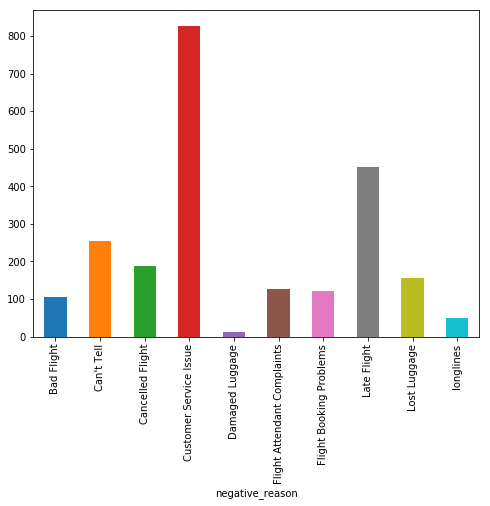

In [76]:
fig = plt.figure(figsize=(8,6))
neg_subusair.groupby('negative_reason').text.count().plot.bar(ylim=0)
plt.show()

From the histogram above, we can clearly see the negative distribution of the Usairways. You can see more than 800 tweets are about Customer Service Issue and more than 400 are about Late Flight. We know that the service of Usairways isn't good enought and the flight is often late. 
If we have a big enough dataset, doing that, we will get a convincing choice of airlines.

# Question_3 Model preparation

In [35]:
X, y = clean_df_2.text, clean_df_2['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.3)
#Split the generic tweets randomly into training data (70%) and test data (30%).

In [36]:
print ("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_train),
                                                                                         (len(X_train[y_train == 0]) / (len(X_train)*1.))*100,
                                                                                         (len(X_train[y_train == 4]) / (len(X_train)*1.))*100))

Train set has total 140000 entries with 50.11% negative, 49.89% positive


In [37]:
print ("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_test),
                                                                                         (len(X_test[y_test == 0]) / (len(X_test)*1.))*100,
                                                                                         (len(X_test[y_test == 4]) / (len(X_test)*1.))*100))

Test set has total 60000 entries with 49.75% negative, 50.25% positive


In [38]:
# Define accuracy_summary function to iteratively train on the different number of features.
def accuracy_summary(pipeline, X_train, y_train, X_test, y_test):
    if len(X_test[y_test == 0]) / (len(X_test)*1.) > 0.5:
        null_accuracy = len(X_test[y_test == 0]) / (len(X_test)*1.)
    else:
        null_accuracy = 1. - (len(X_test[y_test == 0]) / (len(X_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(X_train, y_train)
    y_pred = sentiment_fit.predict(X_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time

In [39]:
cvec = CountVectorizer()
lr = LogisticRegression(class_weight="balanced")
n_features = np.arange(10000,100001,10000)

In [40]:
# check the accuracy of logistic regression on the test set
def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,nfeature_accuracy,tt_time))
    return result

As a result, I will extend the bag-of-words to bigrams, and see how it affects the performance.

In [41]:
# n-gram
print("RESULT FOR UNIGRAM\n")
feature_result_ug = nfeature_accuracy_checker(ngram_range=(1, 1))
print("RESULT FOR BIGRAM\n")
feature_result_bg = nfeature_accuracy_checker(ngram_range=(1, 2))
print("RESULT FOR TRIGRAM\n")
feature_result_tg = nfeature_accuracy_checker(ngram_range=(1, 3))

RESULT FOR UNIGRAM

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


Validation result for 10000 features


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.25%
accuracy score: 76.27%
model is 26.02% more accurate than null accuracy
train and test time: 4.55s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.25%
accuracy score: 76.23%
model is 25.98% more accurate than null accuracy
train and test time: 4.56s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.25%
accuracy score: 76.26%
model is 26.01% more accurate than null accuracy
train and test time: 4.95s
--------------------------------------------------------------------------------
Validation result for 40000 features
null accuracy: 50.25%
accuracy score: 76.28%
model is 26.04% more accurate than null accuracy
train and test time: 5.25s
--------------------------------------------------------------------------------
Validation result for 50000 features
null accuracy: 50.25%
accuracy score: 76.26%

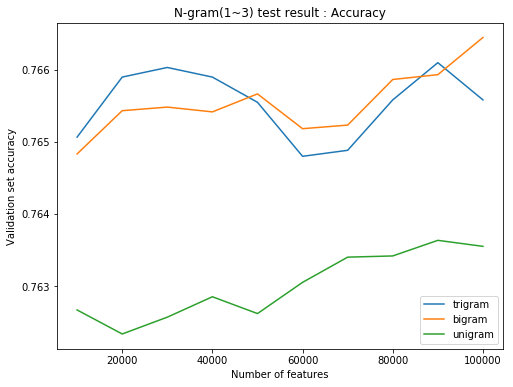

In [42]:
# Plot the results of unigram, bigram, trigram together on a graph as below.
nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

unigram: 90,000 features at validation accuracy 76.38%

bigram: 100,000 features at validation accuracy 76.65%

trigram: 90,000 features at validation accuracy 76.62%

## Question_4 Model implementation

In [43]:
# define another function to take a closer look at best performing number of features with bigram, and give classification report.
def train_test_and_evaluate(pipeline, X_train, y_train, X_test, y_test):
    if len(X_test[y_test == 0]) / (len(X_test)*1.) > 0.5:
        null_accuracy = len(X_test[y_test == 0]) / (len(X_test)*1.)
    else:
        null_accuracy = 1. - (len(X_test[y_test == 0]) / (len(X_test)*1.))
    sentiment_fit = pipeline.fit(X_train, y_train)
    y_pred = sentiment_fit.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("-"*80)
    print("Classification Report\n")
    print(classification_report(y_test, y_pred, target_names=['negative','positive']))

In [44]:
%%time
bg_cvec = CountVectorizer(max_features=100000,ngram_range=(1, 2))
bg_pipeline = Pipeline([
        ('vectorizer', bg_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(bg_pipeline, X_train, y_train, X_test, y_test)

null accuracy: 50.25%
accuracy score: 76.64%
model is 26.40% more accurate than null accuracy
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    negative       0.77      0.75      0.76     29851
    positive       0.76      0.78      0.77     30149

   micro avg       0.77      0.77      0.77     60000
   macro avg       0.77      0.77      0.77     60000
weighted avg       0.77      0.77      0.77     60000

CPU times: user 10.7 s, sys: 155 ms, total: 10.8 s
Wall time: 10.8 s


From the above classification reports, we can see that model has slightly higher precision in negative class and higher recall in positive class. But this averages out by calculating the F1 score, and for both classes, we get the almost same F1 score for both positive and negative class.

#### Evaluate the same model on the US airline data.

In [45]:
y_air = [1 if df_1['sentiment'][i] == 'positive' else 0 for i in range(df_1.shape[0])]

In [46]:
sentiment_fit_air = bg_pipeline.fit(X_train, y_train)
THRESHOLD = 0.25
y_pred_air = sentiment_fit_air.predict_proba(clean_df.text)[:,1] >= THRESHOLD
accuracy_air = accuracy_score(y_air, y_pred_air)
print("accuracy score: {0:.2f}%".format(accuracy_air*100))

accuracy score: 59.48%


#### Train a multi-class logistic regression model to predict the reason for the negative tweets. 

In [47]:
negative_usair = clean_df.loc[clean_df['sentiment_num'] == 0] # Extract negative tweets for all tweets of us_airline tweets.

In [48]:
# Add a column encoding the negative_reason as an integer because categorical variables are often better represented 
# by integers than strings.
# And also create a couple of dictionaries for future use.
negative_usair['reason_id'] = negative_usair['negative_reason'].factorize()[0]
reason_id_df = negative_usair[['negative_reason', 'reason_id']].drop_duplicates().sort_values('reason_id')
reason_to_id = dict(reason_id_df.values)
id_to_reason = dict(reason_id_df[['reason_id', 'negative_reason']].values)
negative_usair.head(5)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,text,sentiment,negative_reason,sentiment_num,reason_id
1,@virginamerica really aggressive blast obnoxio...,negative,Bad Flight,0,0
2,@virginamerica really big bad thing,negative,Can't Tell,0,1
3,@virginamerica seriously would pay $30 flight ...,negative,Can't Tell,0,1
11,@virginamerica sfo-pdx schedule still mia.,negative,Late Flight,0,2
13,@virginamerica flew nyc sfo last week could fu...,negative,Bad Flight,0,0


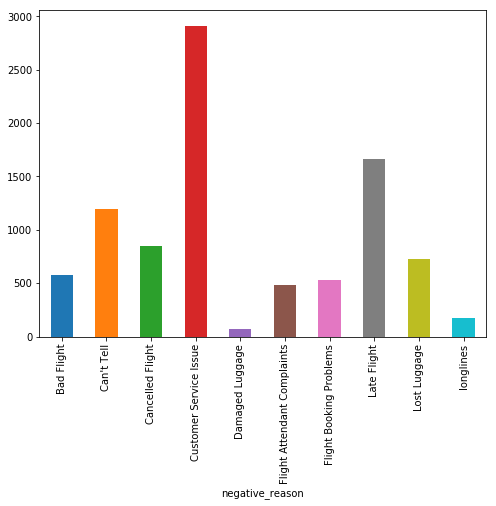

In [49]:
fig = plt.figure(figsize=(8,6))
negative_usair.groupby('negative_reason').text.count().plot.bar(ylim=0)
plt.show()

We see that the number of reason per negative reason is imbalanced. Negative reasons are more biased towards Customer Services Issue, Late Flight and Can't tell.

In [50]:
# Calculate a measure called tf-idf vector for each of text.
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(negative_usair.text).toarray()
labels = negative_usair.reason_id
features.shape

(9178, 3331)

Now, each of 9178 text is represented by 3331 features, representing the tf-idf score for different unigrams and bigrams.

In [51]:
# Find the terms that are the most correlated with each of the negative reasons.
N = 2
for negative_reason, reason_id in sorted(reason_to_id.items()):
  features_chi2 = chi2(features, labels == reason_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(negative_reason))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bad Flight':
  . Most correlated unigrams:
. seat
. wifi
  . Most correlated bigrams:
. southwestair wifi
. inflight wifi
# 'Can't Tell':
  . Most correlated unigrams:
. fleet
. fleek
  . Most correlated bigrams:
. fleet fleek
. jetblue fleet
# 'Cancelled Flight':
  . Most correlated unigrams:
. flightled
. cancelled
  . Most correlated bigrams:
. flight cancelled
. cancelled flightled
# 'Customer Service Issue':
  . Most correlated unigrams:
. service
. customer
  . Most correlated bigrams:
. hold hours
. customer service
# 'Damaged Luggage':
  . Most correlated unigrams:
. broke
. damaged
  . Most correlated bigrams:
. united received
. baggage handlers
# 'Flight Attendant Complaints':
  . Most correlated unigrams:
. attendant
. attendants
  . Most correlated bigrams:
. flight attendant
. flight attendants
# 'Flight Booking Problems':
  . Most correlated unigrams:
. booked
. book
  . Most correlated bigrams:
. trying book
. book flight
# 'Late Flight':
  . Most correlated unigrams

In [52]:
# Split the negative US airline tweets into training data (70%) and test data (30%).
X_train_1, X_test_1, y_train_1, y_test_1, indices_train, indices_test = train_test_split(features, labels, negative_usair.index, test_size=0.3, random_state=0)

In [53]:
model = LogisticRegression(random_state=0)
model.fit(X_train_1, y_train_1)
y_pred_1 = model.predict(X_test_1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [54]:
# Again, we use the chi-squared test to find the terms that are the most correlated with each of the categories.
model.fit(features, labels)
N = 2
for negative_reason, reason_id in sorted(reason_to_id.items()):
  indices = np.argsort(model.coef_[reason_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(negative_reason))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


# 'Bad Flight':
  . Top unigrams:
       . wifi
       . seat
  . Top bigrams:
       . united dm
       . inflight wifi
# 'Can't Tell':
  . Top unigrams:
       . united
       . jetblue
  . Top bigrams:
       . worst airline
       . united airlines
# 'Cancelled Flight':
  . Top unigrams:
       . cancelled
       . flightled
  . Top bigrams:
       . cancelled flightled
       . flight cancelled
# 'Customer Service Issue':
  . Top unigrams:
       . hold
       . phone
  . Top bigrams:
       . customer service
       . southwestair hold
# 'Damaged Luggage':
  . Top unigrams:
       . damaged
       . luggage
  . Top bigrams:
       . united received
       . bad experience
# 'Flight Attendant Complaints':
  . Top unigrams:
       . staff
       . rude
  . Top bigrams:
       . flight attendants
       . flight attendant
# 'Flight Booking Problems':
  . Top unigrams:
       . book
       . booked
  . Top bigrams:
       . book flight
       . booking problems
# 'Late Flight':
  . T

They are consistent within our expectation.

In [55]:
accuracy_negair = accuracy_score(y_test_1, y_pred_1)
print("accuracy score: {0:.2f}%".format(accuracy_negair*100))

accuracy score: 59.88%


In [56]:
print(metrics.classification_report(y_test_1, y_pred_1, target_names=negative_usair['negative_reason'].unique()))

                             precision    recall  f1-score   support

                 Bad Flight       0.62      0.21      0.31       190
                 Can't Tell       0.42      0.43      0.43       339
                Late Flight       0.63      0.74      0.68       504
     Customer Service Issue       0.57      0.82      0.68       897
    Flight Booking Problems       0.60      0.16      0.26       147
               Lost Luggage       0.73      0.67      0.70       202
Flight Attendant Complaints       0.75      0.16      0.26       153
           Cancelled Flight       0.80      0.70      0.74       246
            Damaged Luggage       0.00      0.00      0.00        21
                  longlines       0.00      0.00      0.00        55

                  micro avg       0.60      0.60      0.60      2754
                  macro avg       0.51      0.39      0.41      2754
               weighted avg       0.60      0.60      0.56      2754



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Question_5 Discussion

#### (1) Analysis based on the first model.

In [57]:
#Based on the first model, as if the ground truth labels were not given, we will get the reasults below.
y_pred_air =sentiment_fit_air.predict_proba(clean_df.text)[:,1] >= 0.25

In [58]:
conmat_model1 = np.array(confusion_matrix(y_air, y_pred_air, labels=[0,1]))
confusion = pd.DataFrame(conmat_model1, index=['negative', 'positive'],
                         columns=['predicted_negative','predicted_positive'])
print("Confusion Matrix\n")
print(confusion)

Confusion Matrix

          predicted_negative  predicted_positive
negative                4636                4542
positive                 134                2229


From the last question, we know the accuracy score is just 59.48%, which can be reached by (4636+2229)/(4636+2229+4542+134). In this analysis, as if the ground truth labels were not given, the result we predict compares with the true labels, we can know the negative ones are predicted well, but the posstive ones are not.

Let's look at the first model fitted by the dataset of the generic tweets, the features are generated by all kinds of tweets, so that there are a lot of different words, which maybe include the words of the tweets of the airline or may not. That's to say, there are only some of the features matches some of the us airline tweets, and the other features of the us airline tweets aren't matched. As a result, using this model on the us airline, it is surely can't get a higher or equal accuracy than applying it to it's test dataset.

Based on the results from the second question, if I transfer the positive sentiment to 4 and the negative to 0, just like another file's class, then I count the times of occurances of every airline,and sum all 0s and 4s to get the total scores of them, then divided them by their occurance number, now we can see form the given dataset that people are satisfied with the virgin america most, then jetblue.   

In order to improve the accuracy of the model, text features can be constructed using from Bag-of-Words to TF-IDF.

In [59]:
tfidf_4 = TfidfVectorizer(max_features=100000, ngram_range=(1, 2))
bg_pipeline_4 = Pipeline([
        ('vectorizer', tfidf_4),
        ('classifier', lr)
    ])
sentiment_fit_4 = bg_pipeline_4.fit(X_train, y_train)
y_pred_4 = sentiment_fit_4.predict(X_test)
accuracy_4 = accuracy_score(y_test, y_pred_4)
print("accuracy score: {0:.2f}%".format(accuracy_4*100))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy score: 77.28%


Now we can see, after using TF-IDF, accuracy improved from 76.64% to 77.28%. Even though it isn't a very big increase, it is still obvious.

#### (2) Analysis based on the second model.

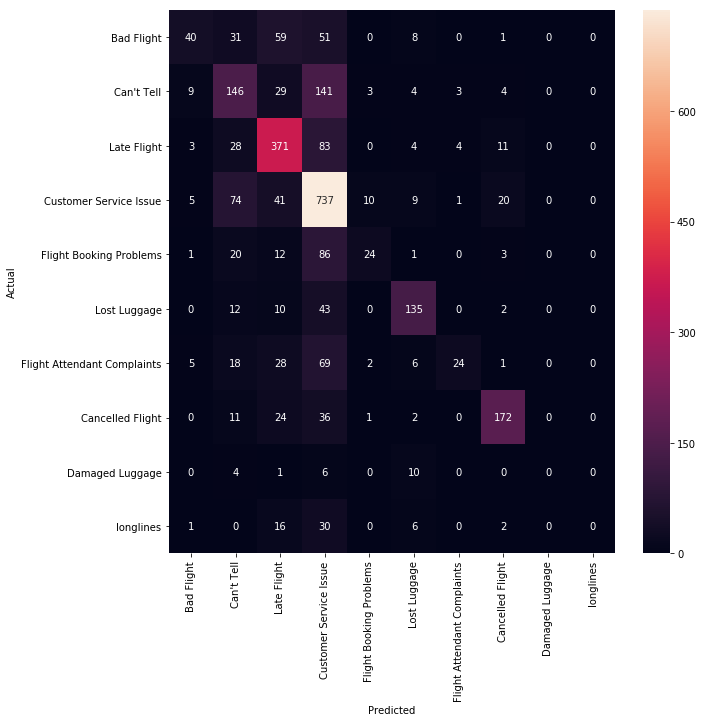

In [60]:
conf_mat = confusion_matrix(y_test_1, y_pred_1)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=reason_id_df.negative_reason.values, yticklabels=reason_id_df.negative_reason.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

From the confusion matrix above, we can see the discrepancies between predicted and actual labels. Even though the vast majority of the predictions end up on the diagonal (predicted label = actual label), there are a number of misclassifications, which need to further explain. And also because the values of Damaged Luggage and longlines are very small based on the analysis of beginning of the fourth question, it is acceptable that their predictd and actual labels don't match.

In [61]:
# In order to see what those misclassifications are caused by, I can display the misclassifications.
for predicted in reason_id_df.reason_id:
  for actual in reason_id_df.reason_id:
    if predicted != actual and conf_mat[actual, predicted] >= 20:
      print("'{}' is predicted as '{}' : {} examples.".format(id_to_reason[actual], id_to_reason[predicted], conf_mat[actual, predicted]))
      display(negative_usair.loc[indices_test[(y_test_1 == actual) & (y_pred_1 == predicted)]][['negative_reason', 'text']])
      print('')

'Bad Flight' is predicted as 'Can't Tell' : 31 examples.


,negative_reason,text
8555,Bad Flight,@usairways please secure 'footrest' shelf' bus...
9281,Bad Flight,@americanair worry. i'll sending letter expect...
1265,Bad Flight,@united everytime fly ur airline hate even ! t...
3570,Bad Flight,"@southwestair ""heart"" southwest commercials ai..."
3162,Bad Flight,@united dang... thought teleportation device! ...
4086,Bad Flight,@southwestair please refund ticket. terrible e...
1385,Bad Flight,"@united tried failed. still wifi ever, last ro..."
4311,Bad Flight,@southwestair cool plane said left terminal di...
22,Bad Flight,@virginamerica amazing get cold air vents. #vx...
1637,Bad Flight,@united allow families small children board fi...



'Late Flight' is predicted as 'Can't Tell' : 28 examples.


,negative_reason,text
5077,Late Flight,@southwestair still stranded dc. sat 3:30am 10...
8440,Late Flight,@usairways worst!! still left.. everyone missi...
6366,Late Flight,"@jetblue simply minor mechanical, would say that?"
6006,Late Flight,made #costa #rica back @jetblue missing alread...
6121,Late Flight,@jetblue cling safety card. safety really issu...
3655,Late Flight,@southwestair prove
3076,Late Flight,@united excuse leaving minor spend night sobbi...
6024,Late Flight,@jetblue boarding i'm really impressed. i've l...
4703,Late Flight,@southwestair friend lucky enough see #destina...
1136,Late Flight,@united that's good enough us affected awful o...



'Customer Service Issue' is predicted as 'Can't Tell' : 74 examples.


,negative_reason,text
5920,Customer Service Issue,@jetblue got wish would communicate w us
5120,Customer Service Issue,@southwestair will.make sure tell everyone kno...
8593,Customer Service Issue,@usairways flight cost $800 happens? fly @unit...
1857,Customer Service Issue,@united please take membership away :(
5760,Customer Service Issue,@jetblue seriously? system down? it?
8163,Customer Service Issue,@usairways pretty hilarious want @sweetingr fi...
8292,Customer Service Issue,@usairways get through?
4362,Customer Service Issue,@southwestair @julgood1 traveling one got misc...
2469,Customer Service Issue,"thanks @united, great news u refund tickets du..."
4399,Customer Service Issue,@southwestair well car & free place 2 stay kno...



'Flight Booking Problems' is predicted as 'Can't Tell' : 20 examples.


,negative_reason,text
751,Flight Booking Problems,@united pedophile airline. split 10 yr old dau...
3159,Flight Booking Problems,@united miles going restructured? help silver ...
8121,Flight Booking Problems,@usairways easily ridiculous experience trying...
7367,Flight Booking Problems,"@usairways chairman preferred 518,758 lifetime..."
10420,Flight Booking Problems,"@americanair pay extra $$ cos flight ""no longe..."
10015,Flight Booking Problems,@americanair fly american family severe weathe...
1110,Flight Booking Problems,@united bull crap. spent $600 recent trip. tha...
3262,Flight Booking Problems,@united mileageplus signup page broken.
2094,Flight Booking Problems,@united certainly not.
1266,Flight Booking Problems,".@united really? bumped gold status, asked pay..."



'Bad Flight' is predicted as 'Late Flight' : 59 examples.


,negative_reason,text
8635,Bad Flight,@usairways flight phf clt. terminal get plane ...
1723,Bad Flight,@united cabin pressurization issues pretty ser...
1559,Bad Flight,@united good luck no-enertainment-on-6-hour-fl...
661,Bad Flight,@united empathizes w/ disappointment 1stclass ...
247,Bad Flight,@virginamerica flight vx399 headed la jfk - di...
3968,Bad Flight,@southwestair plane switch 636 meant a= back p...
6124,Bad Flight,@jetblue flight 669 forced return ny malfuncti...
5429,Bad Flight,@jetblue else plane duct-taped?? #ohboy #shoul...
1465,Bad Flight,"@united broken light, 35 mins get bridge gate,..."
4720,Bad Flight,@southwestair first flight ever flight #4251 a...



'Can't Tell' is predicted as 'Late Flight' : 29 examples.


,negative_reason,text
7533,Can't Tell,@usairways lose pilot????
9785,Can't Tell,@americanair @united @spiritairpr @fioretti2nd...
477,Can't Tell,@united maybe one day one quoted
8448,Can't Tell,@usairways never again! worse experience life.
3108,Can't Tell,@united getting ridiculous. we're missing conn...
2125,Can't Tell,@united miss continental days.
1584,Can't Tell,@united weight restriction? 'we'll try get man...
5789,Can't Tell,@jetblue ok got far atlantic city due jfk clos...
1157,Can't Tell,@united maybe find different gate #ua1758
2622,Can't Tell,@united flight heavy fly back palm springs (af...



'Customer Service Issue' is predicted as 'Late Flight' : 41 examples.


,negative_reason,text
7142,Customer Service Issue,@usairways system affected weather?
5787,Customer Service Issue,@jetblue note time taken (now 906 am) flight s...
3188,Customer Service Issue,@united - flight 1114. unfortunately isolate f...
7790,Customer Service Issue,"@usairways point need sorry, need revers agt p..."
10805,Customer Service Issue,@americanair i'm home & 9hr late flight. thank...
5284,Customer Service Issue,@jetblue seat assignment 5 mins flight...line ...
8525,Customer Service Issue,"@usairways appreciate calls flight's delayed, ..."
5310,Customer Service Issue,@jetblue understand ur it. someone traveled 2+...
6548,Customer Service Issue,@jetblue shout crew flight 89 headed back big ...
10960,Customer Service Issue,@americanair dropping ball. again. catering. p...



'Flight Attendant Complaints' is predicted as 'Late Flight' : 28 examples.


,negative_reason,text
874,Flight Attendant Complaints,@united today take flight san francisco. .. re...
9113,Flight Attendant Complaints,@usairways please staff flights approproately....
4304,Flight Attendant Complaints,@southwestair staff really kind flight delay. ...
11233,Flight Attendant Complaints,@americanair flight 1081 iad lax sat 3hrs grou...
866,Flight Attendant Complaints,@united arriving airport 2 hours departure tim...
9539,Flight Attendant Complaints,"@americanair lots upset people, freezing termi..."
7879,Flight Attendant Complaints,@usairways hello?! four hours since plane land...
1795,Flight Attendant Complaints,"@united god damn fucking crew till 6:40, known..."
2652,Flight Attendant Complaints,@united concerned close club paid alot 10. las...
6614,Flight Attendant Complaints,"@jetblue yes, today. flight full now. said gat..."



'Cancelled Flight' is predicted as 'Late Flight' : 24 examples.


,negative_reason,text
9800,Cancelled Flight,@americanair flights via united arrive dfw car...
8761,Cancelled Flight,@usairways @marciaveronicaa missed uncle's fun...
1061,Cancelled Flight,"@united 2nd time rebooked (w/delays), reasons ..."
11330,Cancelled Flight,@americanair flight miami dallas monday resche...
2412,Cancelled Flight,@united haha clean plane held overnight hangar...
3089,Cancelled Flight,.@united: landed. day late flight almost sleep...
7489,Cancelled Flight,@usairways flights philly system wide tech iss...
6148,Cancelled Flight,@jetblue stranded passengers helped get anothe...
7501,Cancelled Flight,@usairways would let us switch different set f...
10460,Cancelled Flight,@americanair sorry enough compensate either ex...



'Bad Flight' is predicted as 'Customer Service Issue' : 51 examples.


,negative_reason,text
2634,Bad Flight,@united would hard worse last time i'm sure gi...
1763,Bad Flight,"@united additionally, husband paid tv service ..."
2696,Bad Flight,@united tried already & tried forgetting wifi ...
7113,Bad Flight,"@usairways usually ""sorry"" involve moving peop..."
1793,Bad Flight,@united fire yr rep refused put flight boardin...
9174,Bad Flight,.@usairways r rebooked. got conflicting info a...
1105,Bad Flight,@united considering it. currently gold @delta....
11355,Bad Flight,@americanair redirect flight without telling m...
4781,Bad Flight,"@southwestair alas, pretty full entertain witt..."
2949,Bad Flight,"@united #1007 houston-bogota engine problem, m..."



'Can't Tell' is predicted as 'Customer Service Issue' : 141 examples.


,negative_reason,text
10594,Can't Tell,@americanair . death dear friend heart broken ...
6884,Can't Tell,@usairways i've flown us airways least five ti...
744,Can't Tell,@united that's real dedication & concern. apol...
524,Can't Tell,@united offering us 8 rooms 32 people #fail
11029,Can't Tell,@americanair whenever cheat goes horribly wron...
4158,Can't Tell,@southwestair no. told call cust service monday
10433,Can't Tell,"@americanair @usairways ""but take meds make se..."
4819,Can't Tell,@southwestair looks like 1 yr anni trip replac...
6214,Can't Tell,@jetblue want seem crazy! already asked twice!
2235,Can't Tell,@united @skywest again! miss one probably aspe...



'Late Flight' is predicted as 'Customer Service Issue' : 83 examples.


,negative_reason,text
9043,Late Flight,@usairways freaking fact fixing engine charlot...
2325,Late Flight,@united cleaning regional jet takes hour?
41,Late Flight,"@virginamerica hi, virgin! i'm hold 40-50 minu..."
11082,Late Flight,@americanair yes get home tomorrow!!!! please
4513,Late Flight,@southwestair last 5 flights consistently ran ...
440,Late Flight,@united yeah sorry there's always problem unit...
8234,Late Flight,"@usairways new slogan ""if want arrive time, pi..."
5840,Late Flight,"@jetblue thanks response! crew patient us, als..."
9041,Late Flight,thanks @usairways trip screwed up. ive move me...
9215,Late Flight,@usairways still says time website btw



'Flight Booking Problems' is predicted as 'Customer Service Issue' : 86 examples.


,negative_reason,text
5005,Flight Booking Problems,@southwestair able rebook another flight. drov...
3060,Flight Booking Problems,"@united ridic cant transfer credit, $400 & you..."
35,Flight Booking Problems,@virginamerica hi! i'm excited $99 lga->dal de...
60,Flight Booking Problems,@virginamerica phone number. find call flight ...
67,Flight Booking Problems,@virginamerica site tripping. i'm trying check...
6914,Flight Booking Problems,@usairways use skyscanner travel agency called...
4623,Flight Booking Problems,@southwestair loyal a-list customers easier ge...
5308,Flight Booking Problems,@jetblue directed mobile website. direct link?...
8231,Flight Booking Problems,@usairways 13 years naval service run travel d...
4232,Flight Booking Problems,@southwestair frustrated. saw seats avail. onl...



'Lost Luggage' is predicted as 'Customer Service Issue' : 43 examples.


,negative_reason,text
10597,Lost Luggage,"@americanair 3days call,bag anyone pick call. ..."
6806,Lost Luggage,@usairways hotels. still work folder business ...
4937,Lost Luggage,@southwestair left ipad flight 1831 erw den. o...
10595,Lost Luggage,@americanair spent hour+ trying check use mili...
3245,Lost Luggage,@united finally memphis. landed 30 minutes ago...
7538,Lost Luggage,@usairways hard unload bags order arrival? 45 ...
1118,Lost Luggage,@united worker told us call we'd talking someo...
2299,Lost Luggage,@united still waiting bag! never got delivered...
10462,Lost Luggage,@americanair work would much better lesson pla...
7460,Lost Luggage,@usairways please help find luggage since one ...



'Flight Attendant Complaints' is predicted as 'Customer Service Issue' : 69 examples.


,negative_reason,text
3520,Flight Attendant Complaints,@southwestair airline people screwed boarding ...
3782,Flight Attendant Complaints,@southwestair - really? carriers staffed got t...
7554,Flight Attendant Complaints,"@usairways thanks you, incurred us approximate..."
2115,Flight Attendant Complaints,"@united assistance what, attitude staff matter..."
7051,Flight Attendant Complaints,@usairways get bs guy door says door closes 10...
7507,Flight Attendant Complaints,@usairways @americanair @gma could worse airli...
7993,Flight Attendant Complaints,@usairways @rylietolbert15 wow would say
10733,Flight Attendant Complaints,@americanair flight #2962 cll @ 0600 let check...
1456,Flight Attendant Complaints,@united work all!! incredibly unfriendly groun...
2162,Flight Attendant Complaints,@united unsmiling rep. told us hotel shuttle c...



'Cancelled Flight' is predicted as 'Customer Service Issue' : 36 examples.


,negative_reason,text
10458,Cancelled Flight,@americanair hahahaha! crazy! well here's anot...
7351,Cancelled Flight,@usairways missed flight. rude csr. flight til...
2026,Cancelled Flight,@united already follow you. one 800-number age...
10152,Cancelled Flight,@americanair lost customer today. flight today...
3937,Cancelled Flight,@southwestair flight 52 got cancelled flightle...
10493,Cancelled Flight,@americanair thanks. took care it. issue ivr u...
7701,Cancelled Flight,"@usairways 3 us, costing $1000 get home today ..."
11238,Cancelled Flight,@americanair flt aa375 02/23 got cncled cant g...
10457,Cancelled Flight,@americanair bring fianc @meerikangas back me!
8960,Cancelled Flight,@usairways reroute bos jax via dca clt instead...



'longlines' is predicted as 'Customer Service Issue' : 30 examples.


,negative_reason,text
9690,longlines,@americanair needs get shit together. 2 counte...
6721,longlines,@usairways stuck 40+ minutes due lavatory issu...
1476,longlines,@united way one person working entire security...
7816,longlines,@sb5551 sounds like @usairways planned better ...
1558,longlines,"@united, fuck closed premier access lines ord...."
7913,longlines,"@usairways wife, sick 3yr-old-twins, waiting l..."
7648,longlines,@usairways 45 minutes moved two feet bze.
4812,longlines,@southwestair guess get airport early! need wa...
9220,longlines,@usairways we've line service desk 1hr 1/2 spot.
3469,longlines,@southwestair poor performance around! paid ex...



'Customer Service Issue' is predicted as 'Cancelled Flight' : 20 examples.


,negative_reason,text
10558,Customer Service Issue,@americanair email phone call nothing. screwed...
9047,Customer Service Issue,@usairways stop reposting autoresponse return ...
7536,Customer Service Issue,@usairways #695 might cancelled flighted? mech...
10003,Customer Service Issue,@americanair bags checked cancelled flightled ...
11163,Customer Service Issue,@americanair trying get someone cancelled flig...
11470,Customer Service Issue,@americanair @actingoutmgmnt make sure remembe...
7185,Customer Service Issue,"@usairways customer service dead. last wk, flt..."
3628,Customer Service Issue,@southwestair genuinely surprised upgrade peop...
8906,Customer Service Issue,@usairways vacations get cancelled flightled h...
10278,Customer Service Issue,@americanair clueless aa. waiting hear 2.5 wee...


As you can see, "can't tell" is a very big question. There are 31 'Bad Flight', 28 'Late Flight', 74 'Customer Service Issue', 20 'Flight Booking Problem' are predicted as 'Can't tell', and 29 'Can't Tell', 141 'Can't Tell' are predicted as 'Late Flight' and 'Customer Service Issue' separately.
And also maybe there are some problems touching not only one subjects, and some problems have something similar, which can't be easily put in one subject, for example, if your flight is late, you should wait longer and can't attend earlier, so there are 28 examples of 'Flight Attendant Complaints' are predicted as 'Late Flight' and if the service during the flight is bad, you can say 'Bad Flight', or you can also complain 'Customer Service Issue'. So this sort of errors will always happen. 

In order to improve the accuracy of the second model, because 'Can't tell' isn't a reason and it is vague and useless, we can remove all the tweets whose negative reason are 'Can't Tell'. What's more, because 'Customer Service Issue' contains a lot, so we can combine some obvious similar reason with customers service issue. For example, we can put 'Flight Booking Problem' into 'Customer Service Issue'.

In [62]:
# Remove all tweets with 'Can't tell' negative reason.
wt_canttell = negative_usair.copy()
wt_canttell = wt_canttell[wt_canttell.reason_id != 1]

In [63]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features_a = tfidf.fit_transform(wt_canttell.text).toarray()
labels_a = wt_canttell.reason_id
features_a.shape

(7988, 3007)

In [64]:
X_train_a, X_test_a, y_train_a, y_test_a, ana_train, ana_test = train_test_split(features_a, 
                                                                                 labels_a, wt_canttell.index, 
                                                                                 test_size=0.3, random_state=0)
model = LogisticRegression(random_state=0)
model.fit(X_train_a, y_train_a)
y_pred_a = model.predict(X_test_a)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [65]:
accuracy_a = accuracy_score(y_test_a, y_pred_a)
print("accuracy score: {0:.2f}%".format(accuracy_a*100))

accuracy score: 65.54%


So you can see, if we remove all the tweets whose negative reasons are 'Can't Tell', the accuracy will improve about 5%.

In [66]:
# Put 'Flight Booking Problems' into 'Customer Service Issue'.
wt_FBP = negative_usair.copy()
wt_FBP['negative_reason'] = wt_FBP['negative_reason'].replace('Flight Booking Problems', 'Customer Service Issue')
wt_FBP['reason_id'] = wt_FBP['reason_id'].replace(4, 3)

In [67]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features_b = tfidf.fit_transform(wt_FBP.text).toarray()
labels_b = wt_FBP.reason_id

In [68]:
X_train_b, X_test_b, y_train_b, y_test_b, bnb_train, bnb_test = train_test_split(features_b, 
                                                                                 labels_b, wt_FBP.index, 
                                                                                 test_size=0.3, random_state=0)
model = LogisticRegression(random_state=0)
model.fit(X_train_b, y_train_b)
y_pred_b = model.predict(X_test_b)

accuracy_b = accuracy_score(y_test_b, y_pred_b)
print("accuracy score: {0:.2f}%".format(accuracy_b*100))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy score: 63.36%


As a result, combining 'Flight Booking Problems' and 'Customer Service Issue' can also improve the accuracy camparing to the original dataset.

## Bonus

#### Explore alternative classification methods and compare their performance to that of the logistic regression model.

We can experiment with different classification methon, evaluate their accuracy and find the source of any potential issues.
We will try Logistic Regression, (Multinomial) Naive Bayes, Linear Support Vector Machine, Random Forest.

In [77]:
classification = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(classification)))
entries = []
features = tfidf.fit_transform(negative_usair.text).toarray()
labels = negative_usair.reason_id
for model in classification:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.


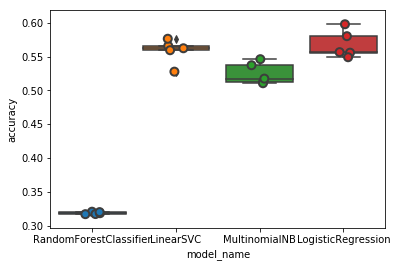

In [78]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [79]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.558398
LogisticRegression        0.567971
MultinomialNB             0.524940
RandomForestClassifier    0.318479
Name: accuracy, dtype: float64

LinearSVC and LogisticRegression perform better than the other two classifiers, with LogisticRegression having a slight advantage with a median accuracy of around 57%. In the question 4, we used the LogisticRegression classifier to train and test the model, it is the best classifier among these four in this dataset.